In [31]:
# Test.py

import os
import sys

PROJECT_ROOT = "/Users/lohitakshbadarala/Desktop/AIM-VEE"
sys.path.append(PROJECT_ROOT)

import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib  # To load saved scaler / PCA

from src.aimvee.models.VEE_predictor import vee_predictor as Model
from src.aimvee.vee_predictor_utils.load_dataset import Dataset
from src.aimvee.vee_predictor_utils.train_utils import eval_epoch



In [32]:
DATA_DIR = "/Users/lohitakshbadarala/Desktop/AIM-VEE/data/vee_predictor/Data"
MODEL_DIR = "/Users/lohitakshbadarala/Desktop/AIM-VEE/models/predictor"
MODEL_PATH = os.path.join(MODEL_DIR, "best_model.pt")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler_X.pkl")
PCA_PATH    = os.path.join(MODEL_DIR, "pca_X.pkl")

CM_TO_EV = 1.239841984e-4  # Convert cm^-1 to eV

In [33]:

# Test.py

import os
import sys

PROJECT_ROOT = "/Users/lohitakshbadarala/Desktop/AIM-VEE"
sys.path.append(PROJECT_ROOT)

import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib  # To load saved scaler / PCA

from src.aimvee.models.VEE_predictor import vee_predictor as Model
from src.aimvee.vee_predictor_utils.load_dataset import Dataset
from src.aimvee.vee_predictor_utils.train_utils import eval_epoch



DATA_DIR = "/Users/lohitakshbadarala/Desktop/AIM-VEE/data/vee_predictor/Data"
MODEL_DIR = "/Users/lohitakshbadarala/Desktop/AIM-VEE/models/predictor"
MODEL_PATH = os.path.join(MODEL_DIR, "best_cm_model.pt")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler_X.pkl")
PCA_PATH    = os.path.join(MODEL_DIR, "pca_X.pkl")

CM_TO_EV = 1.239841984e-4  # Convert cm^-1 to eV
DATA_DIR = "/Users/lohitakshbadarala/Desktop/AIM-VEE/data/vee_predictor/Data"
MODEL_DIR = "/Users/lohitakshbadarala/Desktop/AIM-VEE/models/predictor"
MODEL_PATH = os.path.join(MODEL_DIR, "best_model.pt")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler_X.pkl")
PCA_PATH    = os.path.join(MODEL_DIR, "pca_X.pkl")

CM_TO_EV = 1.239841984e-4  # Convert cm^-1 to eV
X_test = np.load(os.path.join(DATA_DIR, "CM_test.npy"))
y_test = np.load(os.path.join(DATA_DIR, "EV_test.npy"))

print("Test shapes:", X_test.shape, y_test.shape)

# Drop invalid targets (y < 0), same as train/val
mask_test = y_test >= 0
print(f"Dropping {np.sum(~mask_test)} invalid test rows (y < 0)")

X_test = X_test[mask_test]
y_test = y_test[mask_test]

# Separate representation (CM) from indices (fid, state)
d_rep = X_test.shape[1] - 2
X_test_rep = X_test[:, :d_rep]   
X_test_idx = X_test[:, d_rep:]   

# Load scaler + PCA fitted on training data

scaler_X: StandardScaler = joblib.load(SCALER_PATH)
pca: PCA = joblib.load(PCA_PATH)

# Apply scaling + PCA to test representation
X_test_rep = scaler_X.transform(X_test_rep)
X_test_rep = pca.transform(X_test_rep)

new_d_rep = X_test_rep.shape[1]
print("Test representation dim after PCA:", new_d_rep)

# Rejoin PCA rep with fid/state
X_test = np.concatenate([X_test_rep, X_test_idx], axis=1)


# Build Dataset + DataLoader
test_ds = Dataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

d_rep    = test_ds.d_rep
n_fids   = test_ds.n_fids
n_states = test_ds.n_states

print(f"[TEST] d_rep={d_rep}, n_fids={n_fids}, n_states={n_states}")

# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")


# Rebuild model with same hyperparameters as training
model = Model(
    d_rep=d_rep,
    n_fids=n_fids,
    n_states=n_states,
    hidden_dim=512,
     emb_dim=32,
    dropout=0.2,
).to(device)

# Load saved weights
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Could not find model checkpoint at {MODEL_PATH}")
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
print(f"Loaded model weights from: {MODEL_PATH}")

# Evaluate on test set
test_mae_cm = eval_epoch(model, test_loader, device=device)
test_mae_ev = test_mae_cm * CM_TO_EV

print(
    f"\nFINAL TEST RESULTS(VEE-predictor):\n"
    f"Test MAE: {test_mae_cm:.2f} cm^-1 ({test_mae_ev:.6f} eV)\n"
)


Test shapes: (130000, 255) (130000,)
Dropping 0 invalid test rows (y < 0)
Test representation dim after PCA: 100
[TEST] d_rep=100, n_fids=5, n_states=10
Using Apple MPS GPU
Loaded model weights from: /Users/lohitakshbadarala/Desktop/AIM-VEE/models/predictor/best_model.pt


/var/folders/qx/550h11x507v2gx31q3c186qm0000gn/T/ipykernel_3920/1023172350.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH,


FINAL TEST RESULTS(VEE-predictor):
Test MAE: 571.47 cm^-1 (0.070853 eV)



In [34]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load test arrays
X_test = np.load(os.path.join(DATA_DIR, "CM_test.npy"))
y_test = np.load(os.path.join(DATA_DIR, "EV_test.npy"))
print("Test shapes:", X_test.shape, y_test.shape)

# Drop invalid targets (y < 0), same as train/val
mask_test = y_test >= 0
print(f"Dropping {np.sum(~mask_test)} invalid test rows (y < 0)")
X_test = X_test[mask_test]
y_test = y_test[mask_test]

# Split representation vs indices (fid, state)
d_rep_raw = X_test.shape[1] - 2
X_test_rep = X_test[:, :d_rep_raw].astype(np.float32)
X_test_idx = X_test[:, d_rep_raw:].astype(np.int64)  # Fid/state should be ints

# Load scaler + PCA fitted on training data
scaler_X: StandardScaler = joblib.load(SCALER_PATH)
pca: PCA = joblib.load(PCA_PATH)

# Apply scaling + PCA to test representation (MUST match training)
X_test_rep = scaler_X.transform(X_test_rep)
X_test_rep = pca.transform(X_test_rep)

d_rep_pca = X_test_rep.shape[1]
print("Test representation dim after PCA:", d_rep_pca)

# Safety check: trained model used N_COMPONENTS=100
expected = getattr(pca, "n_components_", None)
if expected is not None:
    assert d_rep_pca == expected, f"PCA dim mismatch: got {d_rep_pca}, expected {expected}"
assert d_rep_pca == 100, f"Expected d_rep=100 (training), got {d_rep_pca}"

# Rejoin [PCA_rep, fid, state]
X_test = np.concatenate([X_test_rep.astype(np.float32), X_test_idx.astype(np.int64)], axis=1)

# Build Dataset + DataLoader
test_ds = Dataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

# Important: use d_rep from PCA, not raw
d_rep = 100
n_fids = test_ds.n_fids
n_states = test_ds.n_states
print(f"[TEST] d_rep={d_rep}, n_fids={n_fids}, n_states={n_states}")

# Device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)

# Rebuild model with SAME hyperparameters as training
model = Model(
    d_rep=d_rep,
    n_fids=n_fids,
    n_states=n_states,
    hidden_dim=512,
    emb_dim=32,
    dropout=0.05,   # <-- match training script
).to(device)

# Load saved weights
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Could not find model checkpoint at {MODEL_PATH}")

state = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state, strict=True)
print(f"Loaded model weights from: {MODEL_PATH}")

# Evaluate on test set
test_mae_cm = eval_epoch(model, test_loader, device=device)
test_mae_ev = test_mae_cm * CM_TO_EV

print(
    f"\nFINAL TEST RESULTS (VEE-predictor):\n"
    f"Test MAE: {test_mae_cm:.2f} cm^-1 ({test_mae_ev:.6f} eV)\n"
)


Test shapes: (130000, 255) (130000,)
Dropping 0 invalid test rows (y < 0)
Test representation dim after PCA: 100
[TEST] d_rep=100, n_fids=5, n_states=10
Using device: mps
Loaded model weights from: /Users/lohitakshbadarala/Desktop/AIM-VEE/models/predictor/best_model.pt


/var/folders/qx/550h11x507v2gx31q3c186qm0000gn/T/ipykernel_3920/3258230400.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_PATH, map_location=d


FINAL TEST RESULTS (VEE-predictor):
Test MAE: 571.47 cm^-1 (0.070853 eV)



In [35]:
def collect_predictions(model, loader, device):
    model.eval()
    ys, preds, fids, states = [], [], [], []

    with torch.no_grad():
        for batch in loader:
            feats  = batch["feats"].to(device).float()
            fid_id = batch["fid_id"].to(device).long()
            state  = batch["state_id"].to(device).long()
            y      = batch["target"].to(device).float()

            y_hat = model(feats, fid_id, state)

            ys.append(y.cpu().numpy())
            preds.append(y_hat.cpu().numpy())
            fids.append(fid_id.cpu().numpy())
            states.append(state.cpu().numpy())

    return (
        np.concatenate(ys),
        np.concatenate(preds),
        np.concatenate(fids),
        np.concatenate(states),
    )

y_true_cm, y_pred_cm, fid_ids, state_ids = collect_predictions(model, test_loader, device)

y_true_ev = y_true_cm * CM_TO_EV
y_pred_ev = y_pred_cm * CM_TO_EV
errors_ev = np.abs(y_pred_ev - y_true_ev)

print("Collected predictions successfully.")


Collected predictions successfully.


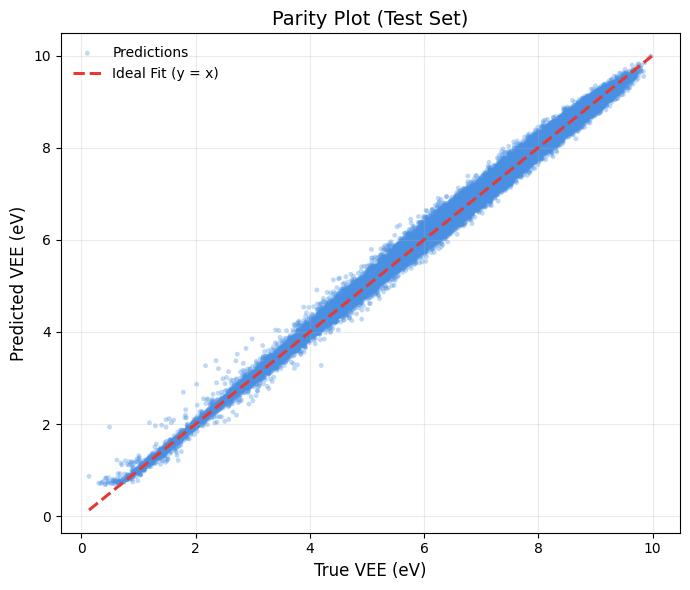

In [36]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,6))

# Scatter points
plt.scatter(
    y_true_ev, 
    y_pred_ev, 
    s=12, 
    alpha=0.35, 
    color="#4A90E2",
    edgecolors="none",
    label="Predictions"
)

# Identity  line
min_val = min(y_true_ev.min(), y_pred_ev.min())
max_val = max(y_true_ev.max(), y_pred_ev.max())
plt.plot(
    [min_val, max_val], 
    [min_val, max_val], 
    color="#E53935",
    linestyle="--", 
    linewidth=2.2,
    label="Ideal Fit (y = x)"
)

# Labels
plt.xlabel("True VEE (eV)", fontsize=12)
plt.ylabel("Predicted VEE (eV)", fontsize=12)
plt.title("Parity Plot (Test Set)", fontsize=14)

# Styling
plt.grid(True, alpha=0.25)
plt.legend(frameon=False, fontsize=10)
plt.tight_layout()

plt.show()


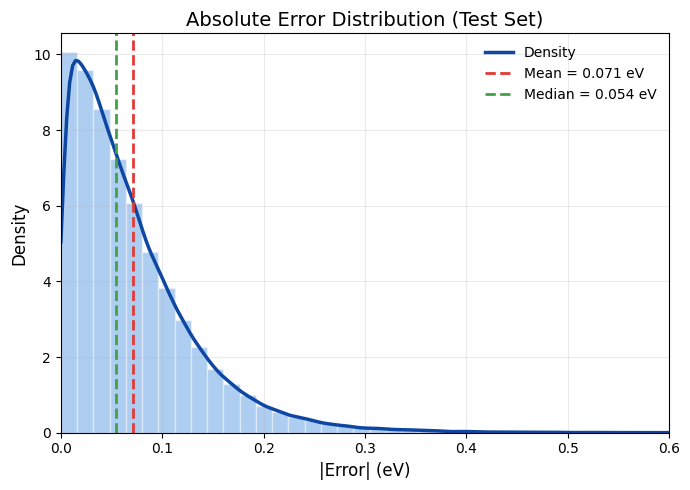

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Compute KDE
kde = gaussian_kde(errors_ev)
x_vals = np.linspace(min(errors_ev), max(errors_ev), 500)

# Compute stats
mean_err = np.mean(errors_ev)
median_err = np.median(errors_ev)

# Plot
plt.figure(figsize=(7,5))

# Histogram
plt.hist(errors_ev, bins=90, density=True, alpha=0.45, color="#4A90E2", edgecolor="white")

# Smoothed KDE line
plt.plot(x_vals, kde(x_vals), color="#0D47A1", linewidth=2.5, label="Density")

# Mean + median vertical lines
plt.axvline(mean_err, color="#E53935", linestyle="--", linewidth=2, label=f"Mean = {mean_err:.3f} eV")
plt.axvline(median_err, color="#43A047", linestyle="--", linewidth=2, label=f"Median = {median_err:.3f} eV")

# Labels & title
plt.xlabel("|Error| (eV)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Absolute Error Distribution (Test Set)", fontsize=14)
plt.xlim(0, 0.6)

# Styling
plt.grid(True, alpha=0.25)
plt.legend(frameon=False, fontsize=10)
plt.tight_layout()

plt.show()


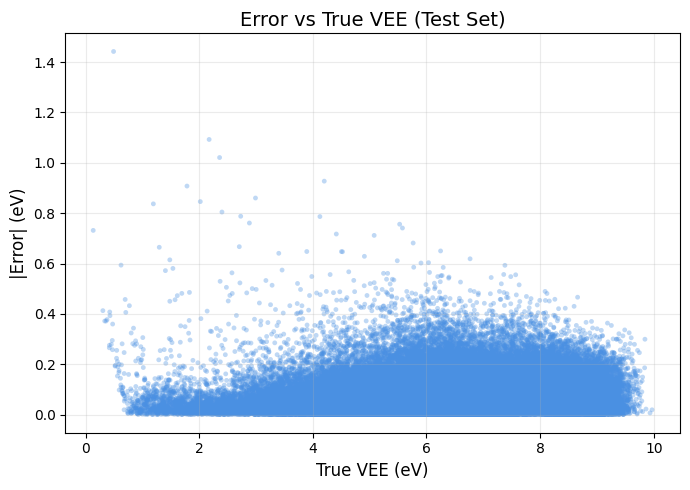

In [38]:


plt.figure(figsize=(7,5))

# Scatter points
plt.scatter(
    y_true_ev,
    errors_ev,
    s=12,
    alpha=0.35,
    color="#4A90E2",
    edgecolors="none",
    label="Error Points"
)

# Labels
plt.xlabel("True VEE (eV)", fontsize=12)
plt.ylabel("|Error| (eV)", fontsize=12)
plt.title("Error vs True VEE (Test Set)", fontsize=14)

# Styling
plt.grid(True, alpha=0.25)
plt.tight_layout()

plt.show()



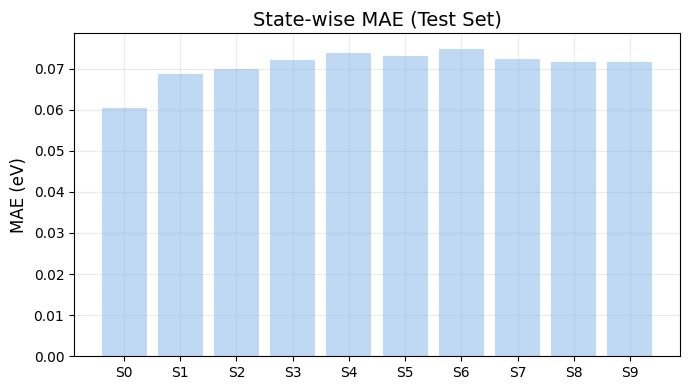

In [39]:
# State-wise MAE H

unique_states = np.unique(state_ids)
mae_by_state = []

for s in unique_states:
    mask = (state_ids == s)
    mae_s = np.mean(np.abs(y_pred_ev[mask] - y_true_ev[mask]))
    mae_by_state.append(mae_s)

plt.figure(figsize=(7,4))
plt.bar([f"S{s}" for s in unique_states], mae_by_state,
        alpha=0.35,
        color="#4A90E2",
        label="Error Points")


plt.ylabel("MAE (eV)", fontsize=12)
plt.title("State-wise MAE (Test Set)", fontsize=14)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()
